### Confidence Intervals - Caleb Wilkins 11/22/2021

In [1]:
# imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

This notebook contains a study on the subject of confidence intervals. We will aim to explore the relationships between the different aspects of a distribution (the background, mean, associated sigma value, etc.) and to what degree of certainty we can measure these important qualities. We are going to need to simulate a background. Let's start with a Poisson distributed background with a mean of 100. 

In [2]:
poisson_bkgd = stats.poisson.rvs(mu=100, size=10000)

Our first goal will be to look at the background distribution and determine where the 5𝜎 sensitivity threshold is.

In [3]:
sigma_threshold = stats.poisson.ppf(stats.norm.cdf(5), 100)
print(f'The 5-sigma sensitivity threshold for the background is {sigma_threshold:.2f}.')

The 5-sigma sensitivity threshold for the background is 154.00.


Now, we will create a fake signal of strength associated with an 8-sigma occurrence and adding 100 samples of it to the background. Let's reverse the problem of finding a sigma threshold and instead calculate what signal value would be associated with an 8-sigma occurrence. 

In [4]:
eight_sigma_prob = stats.norm.cdf(8)
eight_sigma_threshold = stats.poisson.ppf(eight_sigma_prob, 100)
one_signal = poisson_bkgd.copy()

for i in range(100):
    one_signal = np.append(one_signal, eight_sigma_threshold + stats.poisson.rvs(100))
    
print(f'The signal we will be injecting is at {eight_sigma_threshold:.1f}.')

The signal we will be injecting is at 190.0.


Now, we will plot a histogram of our background with the injected signal, along with the same on a semi-log axis in order to better observe the behavior of the distribution. This will allow us to visually observe how bright the signal appears to be.

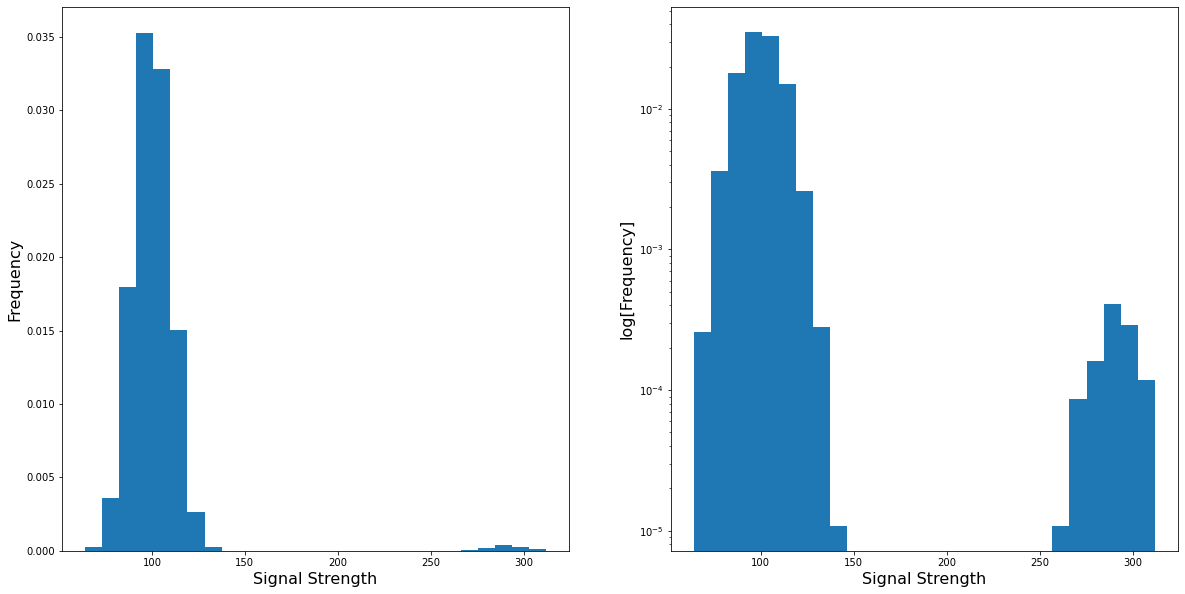

In [5]:
plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(one_signal, density=True, bins = 27)
ax[0].set_xlabel('Signal Strength', fontsize=16)
ax[0].set_ylabel('Frequency', fontsize=16)

ax[1].hist(one_signal, density=True, bins = 27)
ax[1].set_yscale('log')
ax[1].set_xlabel('Signal Strength', fontsize=16)
ax[1].set_ylabel('log[Frequency]', fontsize=16);

We conclude that when the Poisson distribution's $\mu$ value is high, it appears to approach a normal distribution. We also now see an extreme outlier to the right of the distribution.

If we consider the $8\sigma$ signal value that we injected into the background at 190 (signal strength), then we can conclude that our observed signal is biased on account of the fact that we see a much higher probability of getting an observed signal that is lower than our injected signal than the probability of getting a signal that is higher than our injected signal. It follows that our observed signal is clearly not symmetric by observation and the same logic just described. 

We will now make a suite of injected signals. We will have a range of injected signal strengths, starting at zero and extending well above $5\sigma$.

In [6]:
def make_pdfs(max_signal):
    size = 1000

    observed = np.zeros(size*size)
    signals = np.zeros(size*size)

    for i in range(size):
        signal = (max_signal / size) * i
        for j in range(size):
            signals[i*size + j] = signal
            observed[i*size + j] = stats.poisson.rvs(mu=100) + signal
            
    return observed, signals

In [7]:
observed, injected_signals = make_pdfs(500)

We can get an even better visual representation of the resulting distribution by using a 2d histogram of the injected (fake) signal vs. our real signal. 

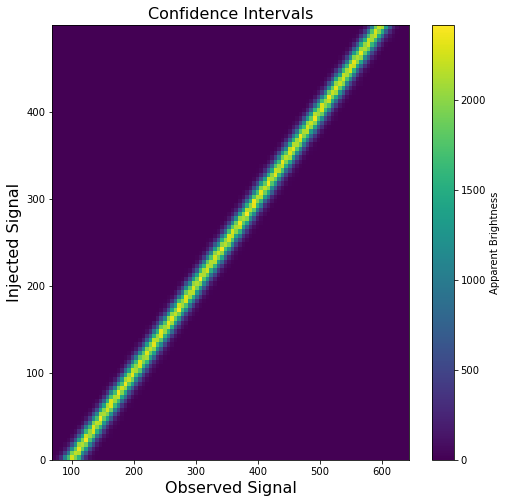

In [8]:
plt.rcParams["figure.figsize"] = (8,8)  

plt.hist2d(observed, injected_signals, bins=100)[0]
plt.xlabel('Observed Signal', fontsize=16)
plt.ylabel('Injected Signal', fontsize=16)
plt.colorbar().set_label('Apparent Brightness')
plt.title('Confidence Intervals', fontsize=16);

Now we can take slices of this 2D array and see that for the same injected signal power as we made prior ($8\sigma$), we get the same answer - as shown below.

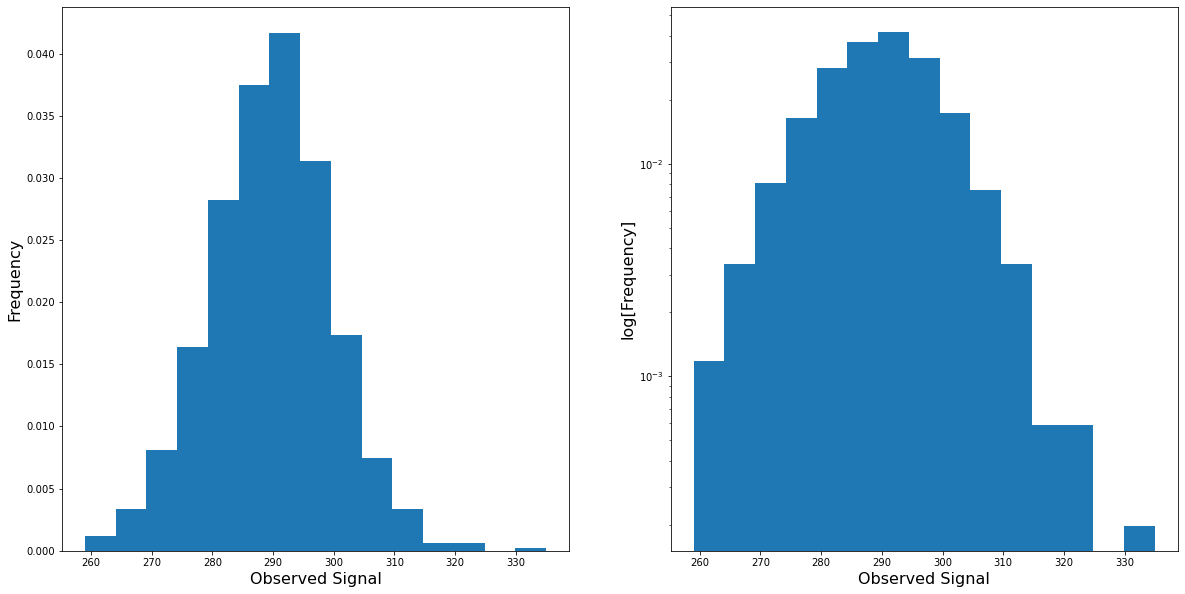

In [9]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(1,2)

signal = 190 # as correlated with an 8-sigma measurement
dist = []

for index in range(injected_signals.size):
    if injected_signals[index] == signal:
        dist.append(observed[index])


ax[0].hist(dist, bins=15, density = True)
ax[0].set_xlabel('Observed Signal', fontsize=16)
ax[0].set_ylabel('Frequency', fontsize=16)

ax[1].hist(dist, bins=15, density = True)
ax[1].set_yscale('log')
ax[1].set_xlabel('Observed Signal', fontsize=16)
ax[1].set_ylabel('log[Frequency]', fontsize=16);

We see that the distribution has a mean equal to the mean of the background plus the strength of the signal, thus we are on the right track. 

Next, say we want to take our observed signal and find all of the injected signals that corrospond to that value. 8-sigma was associated with a signal at a value of 190, so choosing a signal at 300 is well above the 5-sigma range.

In [10]:
signal = 300
new_dist = []

for i in range(observed.size):
    if observed[i] == signal:
        new_dist.append(injected_signals[i])

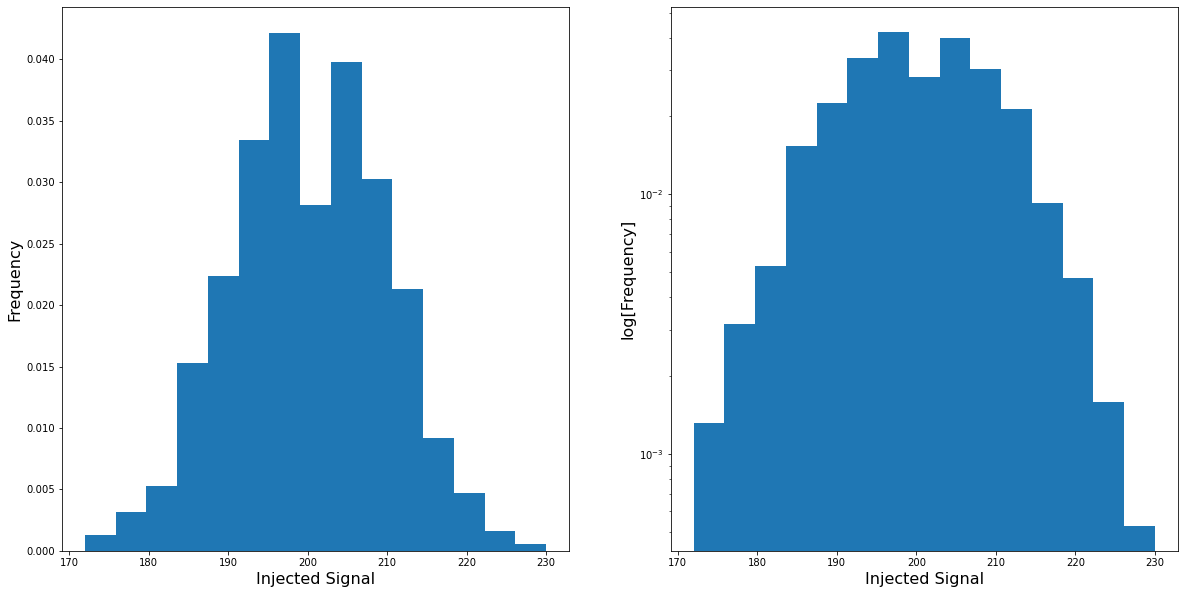

In [11]:
plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(new_dist, bins=15, density=True)
ax[0].set_xlabel('Injected Signal', fontsize=16)
ax[0].set_ylabel('Frequency', fontsize=16)

ax[1].hist(new_dist, bins=15, density=True)
ax[1].set_yscale('log')
ax[1].set_xlabel('Injected Signal', fontsize=16)
ax[1].set_ylabel('log[Frequency]', fontsize=16);

We observe that if our observed signal has a mean probability of 300, then our injected signal will have a mean probability of 200, which is consistent with our background having a mean of 100. 

Suppose we want to find the $1\sigma$ uncertainty, which means we need to find what the bounds about our mean are such that: 

$$\int_{\mu - \sigma}^{\mu + \sigma} PDF(\mu) = 68.27\%$$

As 1$\sigma$ is associated with a probability of about 68%.

Thus,

In [12]:
mu = np.average(new_dist)
one_sigma_uncertainty = 0.6827
total = 0
sigma = 10

while total < one_sigma_uncertainty:
    sigma += 0.001
    count = 0
    for signal in new_dist:
        if abs(signal - mu) < sigma:
            count += 1
    total = count / len(new_dist)
    
print('Sigma:',sigma)

Sigma: 10.001


Therefore, within an error range of $\frac{1}{1000}$, our $\sigma$ is about 10.047. We can explore what this means by plotting vertical lines on our histogram. Zooming in on the mean will lend itself to finding out if our distribution is symmetric or biased in some way.

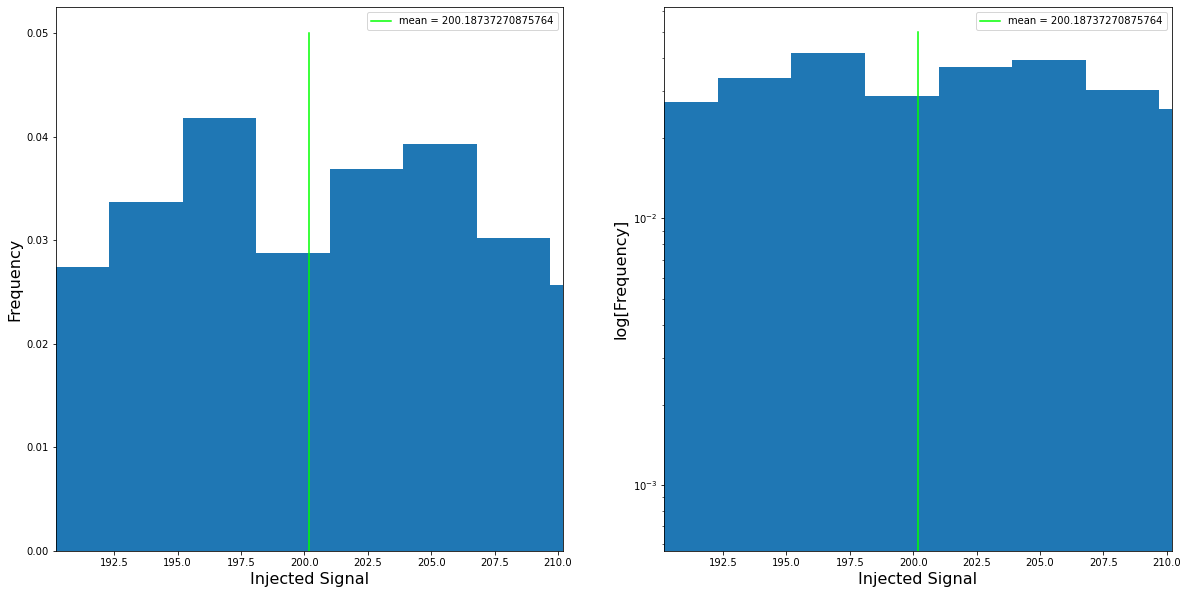

In [13]:
plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(new_dist, bins=20, density=True)
ax[0].set_xlabel('Injected Signal', fontsize=16)
ax[0].set_ylabel('Frequency', fontsize=16)
ax[0].set_xlim([mu - sigma, mu + sigma])
ax[0].plot([mu, mu], [0, 0.05], color='lime', label='mean = ' + str(mu))
ax[0].legend(loc=0)

ax[1].hist(new_dist, bins=20, density=True)
ax[1].set_yscale('log')
ax[1].set_xlabel('Injected Signal', fontsize=16)
ax[1].set_ylabel('log[Frequency]', fontsize=16)
ax[1].set_xlim([mu - sigma, mu + sigma])
ax[1].plot([mu, mu], [0, 0.05], color='lime', label='mean = ' + str(mu))
ax[1].legend(loc=0);

The expected value of the mean is 200, but looking closely we can see that the observed mean is ever so slightly shifted to the right. This wouldn't alarm us that the distribution is significantly biased since the mean of the injected signal is very close to the expected value of 200. The skewness of the distribution could be expected since Poisson distributions are always right skewed since they are bounded as $[0, \inf)$.